Running Day 5 Integration Test...


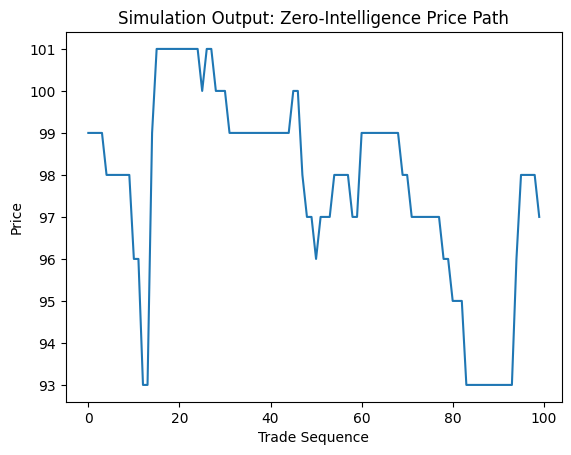

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from dataclasses import dataclass
import matplotlib.pyplot as plt

# --- 1. The Core Matching Engine 
class OrderBook:
    def __init__(self, initial_price=100.0):
        self.bids = []  
        self.asks = []  
        self.trades = [] 

    def add_order(self, current_step, side, price, quantity):
        """
        Updated to accept the time step (5 arguments total including self)
        """
        if side == 'buy':
            self.bids.append([price, quantity, current_step])
            # Sort Bids: Descending (Highest is Best)
            self.bids = sorted(self.bids, key=lambda x: x[0], reverse=True)
        else:
            # CHANGE: Store current_step in the list
            self.asks.append([price, quantity, current_step])
            # Sort Asks: Ascending (Lowest is Best)
            self.asks = sorted(self.asks, key=lambda x: x[0])
            
        self.match()

    def match(self):
        while self.bids and self.asks and self.bids[0][0] >= self.asks[0][0]:
            best_bid = self.bids[0] 
            best_ask = self.asks[0] 
            
            trade_price = best_bid[0]
            trade_qty = min(best_bid[1], best_ask[1])
            
            self.trades.append({'price': trade_price, 'qty': trade_qty})
            
            best_bid[1] -= trade_qty
            best_ask[1] -= trade_qty
            
            if best_bid[1] == 0:
                self.bids.pop(0)
            if best_ask[1] == 0:
                self.asks.pop(0)

    def get_l2_state(self, depth=5):
        bid_prices = [order[0] for order in self.bids[:depth]]
        ask_prices = [order[0] for order in self.asks[:depth]]
        bid_prices += [0] * (depth - len(bid_prices))
        ask_prices += [0] * (depth - len(ask_prices))
        return np.array(bid_prices + ask_prices, dtype=np.float32)

# --- 2. The Gymnasium Environment (The API) ---
class TradingEnv(gym.Env):
    """
    Custom Environment that follows gym interface.
    This connects the Agent to the OrderBook.
    """
    def __init__(self):
        super(TradingEnv, self).__init__()
        self.book = OrderBook()
        self.current_step = 0
        
        # Action Space: [Side (0=Buy, 1=Sell), Price_Offset, Quantity]
        self.action_space = spaces.Box(low=np.array([0, -5, 1]), high=np.array([1, 5, 100]), dtype=np.int32)
        
        # Observation Space: Top 5 Bids + Top 5 Asks
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(10,), dtype=np.float32)

    def reset(self, seed=None):
        self.book = OrderBook() 
        self.current_step = 0
        # Seed the book with initial liquidity
        self.book.add_order(0, 'buy', 99.0, 10)
        self.book.add_order(0, 'sell', 101.0, 10)
        return self.book.get_l2_state(), {}

    def step(self, action):
        self.current_step += 1
        
        # 1. Parse Action
        side_idx, price_offset, qty = action
        side = 'buy' if side_idx < 0.5 else 'sell'
        
        # Determine price relative to market (Simple Logic)
        best_bid = self.book.bids[0][0]if self.book.bids else 100
        base_price = best_bid
        price = base_price + price_offset
        
        # 2. Execute in Engine
        self.book.add_order(self.current_step, side, price, int(qty))
        
        # 3. Return Observation
        observation = self.book.get_l2_state()
        reward = 0 # No reward logic for zero-intelligence agent
        done = self.current_step > 100 # Day ends after 100 steps
        
        return observation, reward, done, False, {}

# --- 3. The Simulation Loop (Agent Interaction) ---
env = TradingEnv()
obs, _ = env.reset()

prices = []

print("Running Day 5 Integration Test...")
for _ in range(100):
    # Random Agent Action (Zero-Intelligence)
    # [Random Side, Random Price Offset (-2 to +2), Random Qty]
    action = [np.random.choice([0, 1]), np.random.randint(-2, 3), np.random.randint(1, 10)]
    
    obs, reward, done, truncated, info = env.step(action)
    
    # Track Last Trade Price
    if env.book.trades:
        prices.append(env.book.trades[-1]['price'])

# Plot
plt.plot(prices)
plt.title("Simulation Output: Zero-Intelligence Price Path")
plt.xlabel("Trade Sequence")
plt.ylabel("Price")
plt.show()